## Project

## Data Munching, Manipulation, and Machine Learning using PySpark.

# 1. Problem: To understand the interrelationship between Alzheimer's Disease and Type 2 Diabetes 

# 1.2 Importing the required libraries 

In [1]:
import findspark
findspark.init()
import pyspark # Call this only after findspark.init()
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import sum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import rank, col, unix_timestamp, from_unixtime, to_timestamp
from pyspark.sql import functions as F
import seaborn as sns
timeFmt = "yyyy-MM-dd"
from pyspark.sql.functions import *

# 1.3 Reading MIMIC data

In [2]:

df = spark.read.csv("mimic_master.csv", header='true', inferSchema='true')
df.show(5)

+---------+---+-------+-----+-----+------+-----+------+-------------------+----------+----------+---------+---------+-------------------+----------+-----------+
|person_id|age|paramCT|gpiCT|ndcCT|ahfsCT|medCT|gender|         birth_date|F_T2D_Diag|F_T1D_Diag|F_LD_Diag|F_KD_Diag|         F_CVD_Diag|F_ALZ_Diag|F_ALZD_Diag|
+---------+---+-------+-----+-----+------+-----+------+-------------------+----------+----------+---------+---------+-------------------+----------+-----------+
|      148| 78|   1815|  224|  224|   224|  224|     F|2029-07-11 00:00:00|      null|      null|     null|     null|2107-09-05 14:58:00|      null|       null|
|      463| 62|    121|   13|   13|    13|   13|     F|2136-09-25 00:00:00|      null|      null|     null|     null|               null|      null|       null|
|      471| 75|    548|   72|   72|    72|   72|     F|2046-08-30 00:00:00|      null|      null|     null|     null|2122-07-22 14:04:00|      null|       null|
|      833|  0|     34|    2|    2

## 1.4 Exploring the dataset

In [3]:
#count row and column 
print((df.count(), len(df.columns)))

(52643, 16)


In [4]:
df.printSchema()

root
 |-- person_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- paramCT: integer (nullable = true)
 |-- gpiCT: integer (nullable = true)
 |-- ndcCT: integer (nullable = true)
 |-- ahfsCT: integer (nullable = true)
 |-- medCT: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- birth_date: timestamp (nullable = true)
 |-- F_T2D_Diag: timestamp (nullable = true)
 |-- F_T1D_Diag: timestamp (nullable = true)
 |-- F_LD_Diag: timestamp (nullable = true)
 |-- F_KD_Diag: timestamp (nullable = true)
 |-- F_CVD_Diag: timestamp (nullable = true)
 |-- F_ALZ_Diag: timestamp (nullable = true)
 |-- F_ALZD_Diag: timestamp (nullable = true)



## 1.5 Selection of Columns

In [5]:
#Certain selected columns as required
df1 = df.select('person_id','age','gender','birth_date','F_T2D_Diag','F_ALZ_Diag','F_ALZD_Diag')

In [6]:
df1.show()

+---------+---+------+-------------------+-------------------+----------+-----------+
|person_id|age|gender|         birth_date|         F_T2D_Diag|F_ALZ_Diag|F_ALZD_Diag|
+---------+---+------+-------------------+-------------------+----------+-----------+
|      148| 78|     F|2029-07-11 00:00:00|               null|      null|       null|
|      463| 62|     F|2136-09-25 00:00:00|               null|      null|       null|
|      471| 75|     F|2046-08-30 00:00:00|               null|      null|       null|
|      833|  0|     M|2137-05-23 00:00:00|               null|      null|       null|
|     1088| 68|     M|2102-03-05 00:00:00|               null|      null|       null|
|     1238|  0|     F|2197-03-27 00:00:00|               null|      null|       null|
|     1342| 72|     F|2034-03-20 00:00:00|               null|      null|       null|
|     1580| 44|     F|2081-05-14 00:00:00|               null|      null|       null|
|     1591|  0|     M|2106-04-01 00:00:00|            

In [7]:
type(df1)

pyspark.sql.dataframe.DataFrame

In [8]:
# Number of Rows and Columns in the sub dataset
print((df1.count(), len(df1.columns)))

(52643, 7)


In [9]:
# Printing the schema of the dataset
df1.printSchema()

root
 |-- person_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- birth_date: timestamp (nullable = true)
 |-- F_T2D_Diag: timestamp (nullable = true)
 |-- F_ALZ_Diag: timestamp (nullable = true)
 |-- F_ALZD_Diag: timestamp (nullable = true)



In [10]:
df1.columns

['person_id',
 'age',
 'gender',
 'birth_date',
 'F_T2D_Diag',
 'F_ALZ_Diag',
 'F_ALZD_Diag']

In [11]:
df1.groupby(["gender"]).count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|23184|
|     M|29459|
+------+-----+



# 2. Creating cohorts

In [12]:
print("Number of records before filter: ", df1.count())
df1.where(F.col("age")==0).count()

Number of records before filter:  52643


7874

# 2.1 Imputing age-0 with current date - date of birth


In [13]:
df1 = df1.withColumn("dummmy_age", ((F.current_timestamp().cast("long") - F.col("birth_date").cast("long"))/365)\
                                            .cast('int'))

df1 = df1.withColumn("age", F.when(F.col('age') == 0, F.col('dummmy_age')).otherwise(F.col('age')))

# if age is still 0 remove those records
df1 = df1.where((F.col("age")>0) & (F.col("age").isNull() == False) & (F.isnan(F.col("age")) == False))
df1.count()

44769

In [14]:
#  Filtering invalid dates as age with 300 or more found in the dataset 
df1 = df1.filter(df1.age <=110)
df1.count()

42496

# 2.2 Create T2D_ONLY based on Age &  F_T2D_Diag


In [15]:
Age_T2D_diag =F.round((F.col("F_T2D_Diag").cast("long") - F.col("birth_date").cast("long"))/(365*60*60*24), 3)
Age_AD_diag =F.round((F.col("F_ALZ_Diag").cast("long") - F.col("birth_date").cast("long"))/(365*60*60*24), 3)
Age_T2DAD_both_diag=F.round((F.col("F_T2D_Diag").cast("long") - F.col("F_ALZ_Diag").cast("long"))/(365*60*60*24), 3)
Age_DEM_diag=F.round((F.col("F_ALZD_Diag").cast("long") - F.col("F_ALZ_Diag").cast("long"))/(365*60*60*24), 3)
Age_T2DDEM_both_diag=F.round((F.col("F_T2D_Diag").cast("long") - F.col("F_ALZD_Diag").cast("long"))/(365*60*60*24), 3)

In [16]:
df1.show(3)

+---------+---+------+-------------------+----------+----------+-----------+----------+
|person_id|age|gender|         birth_date|F_T2D_Diag|F_ALZ_Diag|F_ALZD_Diag|dummmy_age|
+---------+---+------+-------------------+----------+----------+-----------+----------+
|      148| 78|     F|2029-07-11 00:00:00|      null|      null|       null|   -748527|
|      463| 62|     F|2136-09-25 00:00:00|      null|      null|       null| -10017471|
|      471| 75|     F|2046-08-30 00:00:00|      null|      null|       null|  -2230109|
+---------+---+------+-------------------+----------+----------+-----------+----------+
only showing top 3 rows



In [17]:
df1.columns

['person_id',
 'age',
 'gender',
 'birth_date',
 'F_T2D_Diag',
 'F_ALZ_Diag',
 'F_ALZD_Diag',
 'dummmy_age']

In [18]:
df1 = df1.withColumn("T2D_ONLY",Age_T2D_diag).withColumn("AD_ONLY",Age_AD_diag).withColumn("BOTH_T2D_AD"\
,Age_T2DAD_both_diag).withColumn("DEM_ONLY",Age_DEM_diag).withColumn("BOTH_AD_DEM",Age_T2DDEM_both_diag)

## 3. Checking and handling of missing data

In [19]:
df1.show()

+---------+---+------+-------------------+-------------------+----------+-----------+----------+--------+-------+-----------+--------+-----------+
|person_id|age|gender|         birth_date|         F_T2D_Diag|F_ALZ_Diag|F_ALZD_Diag|dummmy_age|T2D_ONLY|AD_ONLY|BOTH_T2D_AD|DEM_ONLY|BOTH_AD_DEM|
+---------+---+------+-------------------+-------------------+----------+-----------+----------+--------+-------+-----------+--------+-----------+
|      148| 78|     F|2029-07-11 00:00:00|               null|      null|       null|   -748527|    null|   null|       null|    null|       null|
|      463| 62|     F|2136-09-25 00:00:00|               null|      null|       null| -10017471|    null|   null|       null|    null|       null|
|      471| 75|     F|2046-08-30 00:00:00|               null|      null|       null|  -2230109|    null|   null|       null|    null|       null|
|     1088| 68|     M|2102-03-05 00:00:00|               null|      null|       null|  -7029462|    null|   null|     

# 3.1 Selecting certain selected columns as required


In [20]:
df1 = df1.select('person_id','age','gender','T2D_ONLY','AD_ONLY')
df1.show(2)

+---------+---+------+--------+-------+
|person_id|age|gender|T2D_ONLY|AD_ONLY|
+---------+---+------+--------+-------+
|      148| 78|     F|    null|   null|
|      463| 62|     F|    null|   null|
+---------+---+------+--------+-------+
only showing top 2 rows



In [21]:
from pyspark.sql.functions import isnan, when, count, col
df1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df1.columns]).show()

+---------+---+------+--------+-------+
|person_id|age|gender|T2D_ONLY|AD_ONLY|
+---------+---+------+--------+-------+
|        0|  0|     0|   30821|  42041|
+---------+---+------+--------+-------+



In [22]:
df1.where((F.col('AD_ONLY').isNull()) | (F.isnan(F.col("AD_ONLY")))).count()

42041

In [23]:
df1.count()

42496

## 4. Imputation of mean in selected null columns

In [24]:
# columns = ['DEM_ONLY'] # T2D_ONLY
# for _col in columns:
#     df_final = df_final.withColumn(_col, F.coalesce(F.col(_col), F.col("age")))

In [25]:
df_final = df1.withColumn("T2D_ONLY", F.when(F.col("T2D_ONLY").isNull() == False, F.lit(1)).otherwise(F.lit(0)))

In [26]:
df_final.show(5)

+---------+---+------+--------+-------+
|person_id|age|gender|T2D_ONLY|AD_ONLY|
+---------+---+------+--------+-------+
|      148| 78|     F|       0|   null|
|      463| 62|     F|       0|   null|
|      471| 75|     F|       0|   null|
|     1088| 68|     M|       0|   null|
|     1342| 72|     F|       0|   null|
+---------+---+------+--------+-------+
only showing top 5 rows



In [27]:
df_final.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_final.columns]).show()

+---------+---+------+--------+-------+
|person_id|age|gender|T2D_ONLY|AD_ONLY|
+---------+---+------+--------+-------+
|        0|  0|     0|       0|  42041|
+---------+---+------+--------+-------+



In [28]:
df_final.groupby(["gender"]).count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|18104|
|     M|24392|
+------+-----+



In [29]:
df_final.crosstab('T2D_ONLY', 'gender').show()

+---------------+-----+-----+
|T2D_ONLY_gender|    F|    M|
+---------------+-----+-----+
|              1| 4925| 6750|
|              0|13179|17642|
+---------------+-----+-----+



## 5. Create target variable

In [30]:
df_final = df_final.withColumn("AD_ONLY", F.when(F.col("AD_ONLY").isNull() == False, F.lit(1)).otherwise(F.lit(0)))

## 5.1 keep only required columns

In [31]:
df_final = df_final.select("AD_ONLY", 'T2D_ONLY', 'age', 'gender', 'person_id')
df_final.show(5, False)

+-------+--------+---+------+---------+
|AD_ONLY|T2D_ONLY|age|gender|person_id|
+-------+--------+---+------+---------+
|0      |0       |78 |F     |148      |
|0      |0       |62 |F     |463      |
|0      |0       |75 |F     |471      |
|0      |0       |68 |M     |1088     |
|0      |0       |72 |F     |1342     |
+-------+--------+---+------+---------+
only showing top 5 rows



# 6. FEATURE ENGINEERING

In [32]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [33]:
df_final.show(2, False)

+-------+--------+---+------+---------+
|AD_ONLY|T2D_ONLY|age|gender|person_id|
+-------+--------+---+------+---------+
|0      |0       |78 |F     |148      |
|0      |0       |62 |F     |463      |
+-------+--------+---+------+---------+
only showing top 2 rows



## 7. Resample Data to increase the % records of Minority class (1 - has ALZ Disease)

### 7.1 Downsampling the Majority class

In [34]:
print("initially records count: ", df_final.where(F.col("AD_ONLY") == 0).count())
down_sampling = df_final.where(F.col("AD_ONLY") == 0).sample(False, 0.5, seed=42)
down_sampling.count()

initially records count:  42041


21124

### 7.2 Upsample the Minority Class

In [35]:
print(df_final.where(F.col("AD_ONLY") == 1).count())
up_sampling = df_final.where(F.col("AD_ONLY") == 1)
for i in range(10):
    up_sampling = up_sampling.unionAll(df_final.where(F.col("AD_ONLY") == 1))
up_sampling.count()

455


5005

In [36]:
print("Minority to Majority class ratio: ", up_sampling.count()/down_sampling.count())

Minority to Majority class ratio:  0.23693429274758568


### 7.3 Combine the minority and mojority class sampled data

In [37]:
resampled_data = up_sampling.unionAll(down_sampling)
resampled_data.count()

26129

### 8. Split into training and test datasets

In [38]:
train, test = resampled_data.randomSplit([0.7, 0.3], seed = 4000)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 18298
Test Dataset Count: 7831


## 9. Apply Transformations on the data

In [39]:
categoricalColumns = ['gender'] # person_id
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'AD_ONLY', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['age', 'T2D_ONLY'] # , 'DEM_ONLY'
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [40]:
pipeline = Pipeline(stages = stages)

# fit pipeline in train data
pipelineModel = pipeline.fit(train)

# transform train data
train = pipelineModel.transform(train)

# transform test data
test = pipelineModel.transform(test)

# 10. MACHINE LEARNING USING SPARK ML ON THE PIPELINED MODEL

In [41]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

## 10.1 LOGISTIC REGRESSION CLASSIFIER

Parameters : maxIter = 50

In [42]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=50)
lrModel = lr.fit(train)

# 10.2 Making predictions on test data using the transform() method.

In [43]:
predictions = lrModel.transform(train)

### 10.3 Precision-Recall & f1-Score

In [44]:
true = [row['label'] for row in predictions.collect()]
preds = [row['prediction'] for row in predictions.collect()]
probs = [row['probability'][0] for row in predictions.collect()]

print(classification_report(true, preds))

              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89     14760
         1.0       0.55      0.30      0.39      3538

    accuracy                           0.82     18298
   macro avg       0.70      0.62      0.64     18298
weighted avg       0.79      0.82      0.79     18298



In [45]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC curve: ', evaluator.evaluate(predictions))

Test Area Under ROC curve:  0.8317928288454733


In [46]:
predictions.crosstab("label", "prediction").show()

+----------------+-----+----+
|label_prediction|  0.0| 1.0|
+----------------+-----+----+
|             1.0| 2480|1058|
|             0.0|13895| 865|
+----------------+-----+----+



In [47]:
def accuracy_m(model): 
    predictions = model.transform(test)
    cm = predictions.select("label", "prediction")
    acc = cm.filter(cm.label == cm.prediction).count() / cm.count()
    print("Model accuracy: %.3f%%" % (acc * 100)) 
accuracy_m(model = lrModel)

Model accuracy: 82.339%


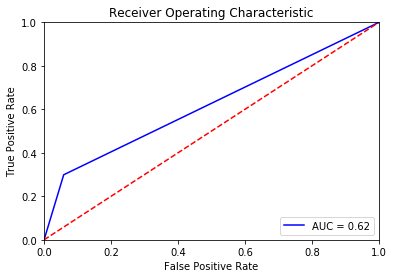

In [48]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(true, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# 11. DECISION TREE CLASSIFIER

In [49]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)

predictions = dtModel.transform(train)
predictions.select('label', 'prediction', 'probability').show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  1.0|       0.0|[0.91328270303781...|
|  1.0|       0.0|[0.91328270303781...|
|  1.0|       0.0|[0.91328270303781...|
|  1.0|       0.0|[0.91328270303781...|
|  1.0|       0.0|[0.91328270303781...|
+-----+----------+--------------------+
only showing top 5 rows



In [50]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC curve for DT classifier : ', evaluator.evaluate(predictions))

Test Area Under ROC curve for DT classifier :  0.26650631892836735


### 11.1. Confusion matrix for Decision tree classifier model

In [51]:
predictions.crosstab("label", "prediction").show()

+----------------+-----+---+
|label_prediction|  0.0|1.0|
+----------------+-----+---+
|             1.0| 2568|970|
|             0.0|14002|758|
+----------------+-----+---+



In [52]:
def accuracy_m(model): 
    predictions = model.transform(test)
    cm = predictions.select("label", "prediction")
    acc = cm.filter(cm.label == cm.prediction).count() / cm.count()
    print("Model accuracy for DT classifier: %.3f%%" % (acc * 100)) 
accuracy_m(model = dtModel)

Model accuracy for DT classifier: 82.097%


### 11.2. Precision-Recall & f1-Score

In [53]:
true = [row['label'] for row in predictions.collect()]
preds = [row['prediction'] for row in predictions.collect()]
probs = [row['probability'][0] for row in predictions.collect()]

print(classification_report(true, preds))

              precision    recall  f1-score   support

         0.0       0.85      0.95      0.89     14760
         1.0       0.56      0.27      0.37      3538

    accuracy                           0.82     18298
   macro avg       0.70      0.61      0.63     18298
weighted avg       0.79      0.82      0.79     18298



### 11.3.  AUC-ROC Plot

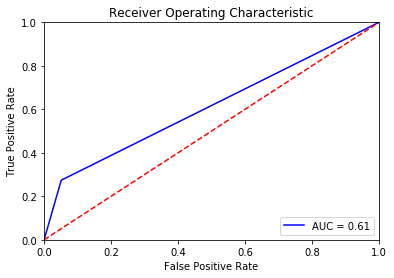

In [54]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(true, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# 12. ENSEMBLE OF DECISION TREES : RANDOM FOREST CLASSIFIER

In [55]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees=5)
rfModel = rf.fit(train)
predictions = rfModel.transform(train)
predictions.select('label','prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  1.0|       0.0|[0.89480516090983...|
|  1.0|       0.0|[0.89480516090983...|
|  1.0|       0.0|[0.89480516090983...|
|  1.0|       0.0|[0.89480516090983...|
|  1.0|       0.0|[0.90848398551416...|
|  1.0|       0.0|[0.90848398551416...|
|  1.0|       0.0|[0.90848398551416...|
|  1.0|       0.0|[0.89480516090983...|
|  1.0|       0.0|[0.89480516090983...|
|  1.0|       0.0|[0.89480516090983...|
+-----+----------+--------------------+
only showing top 10 rows



In [56]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC curve for RF classifier : ', evaluator.evaluate(predictions))

Test Area Under ROC curve for RF classifier :  0.7876350226193047


In [57]:
true = [row['label'] for row in predictions.collect()]
preds = [row['prediction'] for row in predictions.collect()]

In [58]:
print(classification_report(true, preds))

              precision    recall  f1-score   support

         0.0       0.83      0.97      0.90     14760
         1.0       0.61      0.16      0.26      3538

    accuracy                           0.82     18298
   macro avg       0.72      0.57      0.58     18298
weighted avg       0.79      0.82      0.77     18298



### 12.1. Confusion matrix for random forest classifier model

In [59]:
predictions.crosstab("label", "prediction").show()

+----------------+-----+---+
|label_prediction|  0.0|1.0|
+----------------+-----+---+
|             1.0| 2957|581|
|             0.0|14389|371|
+----------------+-----+---+



In [60]:
def accuracy_m(model): 
    predictions = model.transform(test)
    cm = predictions.select("label", "prediction")
    acc = cm.filter(cm.label == cm.prediction).count() / cm.count()
    print("Model accuracy for RF classifier: %.3f%%" % (acc * 100)) 
accuracy_m(model = rfModel)

Model accuracy for RF classifier: 82.250%


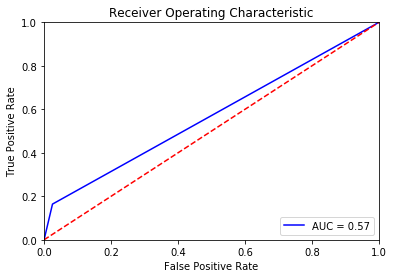

In [61]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(true, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()